In [49]:
import sys
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
from scipy.misc import imresize, imsave
import numpy as np


from model import EncoderDecoder
from util import count_num_samples

TRAIN_PATH = 'data'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 4
epochs = 2

datagen = ImageDataGenerator()
gen = datagen.flow_from_directory(TRAIN_PATH, target_size=TARGET_SIZE,
                                  batch_size=BATCH_SIZE, class_mode=None)


def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        test_img = image.load_img(test_img_path)
        test_img = imresize(test_img, (256, 256, 3))
        test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            imsave(out_path, output_img)

        self.iteration += 1


gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)

num_samples = count_num_samples(TRAIN_PATH)
steps_per_epoch = num_samples // BATCH_SIZE

# target_layer = int(sys.argv[1])

for i in range(1,6):
    target_layer = int(i)

    encoder_decoder = EncoderDecoder(target_layer=target_layer)

    callbacks = [OutputPreview(encoder_decoder, './doge-256.jpg', 5000, './preview-%d' % target_layer)]
    encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
            epochs=epochs, callbacks=callbacks, verbose=0)
    encoder_decoder.export_decoder()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Loading decoders...


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading VGG...


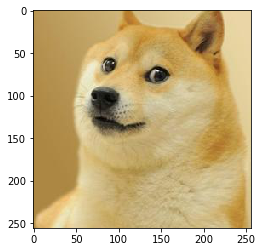

Styling...


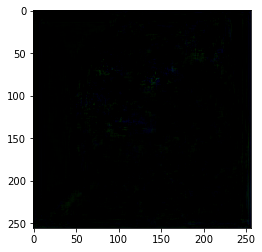

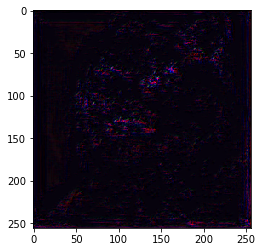

Saving output...


IndexError: list index out of range

In [50]:
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np
from scipy.misc import imsave

from vgg import VGG19, preprocess_input

def get_vgg_features(vgg, inputs, target_layer):
    output_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1'
    ]

    outputs = [layer.output for layer in vgg.layers
               if layer.name == output_layers[target_layer-1]]
    f = K.function([vgg.input] + [K.learning_phase()], outputs)
    return f([inputs, 1.])


def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py

       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)



# img_c = image.load_img(sys.argv[1])
img_c = image.load_img('./doge-256.jpg')

img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape
img_c = np.expand_dims(img_c, axis=0)

# img_s = image.load_img(sys.argv[2])
img_s = image.load_img('./data/starrynight.jpg')

img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape
img_s = np.expand_dims(img_s, axis=0)

assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))

input_shape = img_c_shape

print('Loading decoders...')
decoders = {}
decoders[1] = load_model('./models/decoder_1.h5')  #/decoder_1.h5
decoders[2] = load_model('./models/decoder_2.h5')  #/decoder_2.h5
decoders[3] = load_model('./models/decoder_3.h5')  #/decoder_3.h5
decoders[4] = load_model('./models/decoder_4.h5')  #/decoder_4.h5
decoders[5] = load_model('./models/decoder_5.h5')  #/decoder_5.h5

print('Loading VGG...')
vgg = VGG19(input_shape=input_shape, target_layer=5)

import matplotlib.pyplot as plt

plt.imshow(np.clip(img_c[0] / 255, 0, 1))
plt.show()

print('Styling...')
for i in [3, 1]:
# for i in [1]:
    feats_c = get_vgg_features(vgg, img_c, i)
    feats_s = get_vgg_features(vgg, img_s, i)
    feats_cs = wct(feats_c, feats_s)
    img_c = decoders[i].predict(feats_cs)
    plt.imshow(np.clip(img_c[0] / 255, 0, 1))
    plt.show()

print('Saving output...')
output_img = img_c[0]

imsave(sys.argv[3], output_img)